## Traditional machine learning
Feature(s): 'SMILES' column

- Copolymer sequence of A and B monomer
- Binary encoding

Target: y_bin

- Binary class

In [1]:
import sys
import os
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from loguru import logger

logger.remove()
logger.add(sys.stderr, level="WARNING")
# Append the parent directory of your package to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', '..')))

In [2]:
import pandas as pd
import numpy as np
import zipfile

path_to_dataset = 'train_polymers.csv'
csv_filename = 'train_polymers.csv'

# Open the file, Correct the encoding and sep if necessary
if path_to_dataset.endswith('.zip'):
    with zipfile.ZipFile(path_to_dataset, 'r') as z:
        # Open the CSV file within the ZIP file
        with z.open(csv_filename) as f:
            # Read the CSV file into a DataFrame
            df = pd.read_csv(f, sep=',', on_bad_lines='warn', index_col = 0)
else:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(path_to_dataset, sep=',', on_bad_lines='warn', index_col = 0)


print('Count of unique smiles:', df.SMILES.unique().shape[0])
print('Count of all of the smiles:', df.shape[0])


Count of unique smiles: 16000
Count of all of the smiles: 16000


In [3]:
# Define mapping
mapping = {'A': 0, 'B': 1}

# Apply mapping and convert sequences to arrays
def encode_sequence(sequence):
    return np.array([mapping[char] for char in sequence.split()])

df['Encoded'] = df['SMILES'].apply(encode_sequence)

In [4]:
display(df.head(5))

,SMILES,y,y_bin,Encoded
0,B B B B A A B B B A B A B B B A B B B B,7.759848,0,"[1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, ..."
1,B B B A A A B B A A B A B A B B B A B B,8.133042,0,"[1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, ..."
2,A A B B A B B A B A B B B B A B B B B B,7.717979,0,"[0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, ..."
3,B B B A B A A A A B A B A B A B B B B B,8.147355,0,"[1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, ..."
4,B B B B B B A B B A B B B B B B B B B A,7.603120,0,"[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, ..."


In [5]:
from MLPipeline import MLmodel, BinTheTarget

Target = ['y_bin']
Features = ['Encoded']
Feature_types = ['numerical']
input = df

In [6]:
def objectiveRandomForestClassifier(trial, model_instance):
    """
    Objective function for Optuna to minimize.
    """
    # Define hyperparameters to tune
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_categorical('max_depth', [None, 10, 20, 30, 40]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 6),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    # Clone the model to ensure a fresh instance each trial
    model_clone = clone(model_instance.model)
    model_clone.set_params(**params)
    
    # Define the score metric
    scoring = 'accuracy'

    # Perform cross-validation
    scores = cross_val_score(model_clone, model_instance.X_train, model_instance.y_train, cv=model_instance.cv, scoring=scoring)

    # Return the average score across all folds
    return scores.mean()


def objectiveXGBClassifier(trial, model_instance):
    """
    Objective function for Optuna to minimize for XGBClassifier.
    """
    # Define hyperparameters to tune
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),  # L2 regularization
    }

    # Clone the model to ensure a fresh instance each trial
    model_clone = clone(model_instance.model)
    model_clone.set_params(**params)
    
    # Define the score metric
    scoring = 'accuracy'

    # Perform cross-validation
    scores = cross_val_score(model_clone, model_instance.X_train, model_instance.y_train, cv=model_instance.cv, scoring=scoring)

    # Return the average score across all folds
    return scores.mean()


In [7]:
MODEL_NAMES = ['RandomForestClassifier', 'XGBClassifier']
TARGETS = [[i] for i in Target ]
TRAIN_SIZES = [100, 500, 1000, 5000]

result = []
for seed in [1, 2, 3]:
    for model_name in MODEL_NAMES:
        for target in TARGETS:
            for train_size in TRAIN_SIZES:
                print(f'RUN: Model:{model_name} / Target:{target} / Train size:{train_size} / Seed:{seed}')
                
                if model_name == 'RandomForestClassifier':
                    objective = objectiveRandomForestClassifier
                elif model_name == 'XGBClassifier':
                    objective = objectiveXGBClassifier

                model = MLmodel(modelType=model_name, 
                df=input,
                randomSeed=seed,
                train_count = train_size,
                test_count = 50, 
                target=target, 
                features=Features, 
                hyperparameter_tuning=True,
                feature_types=Feature_types,
                optimization_method='optuna', 
                optimization_trials=10,
                objective=lambda trial: objective(trial, model)
                )

                model.train()
                eval, summary = model.evaluate()
                result.append({**summary, **eval, 'seed':seed})



[I 2024-09-17 16:46:30,141] A new study created in memory with name: no-name-7790be5e-7046-4f7a-b365-6a683099ebf7
[I 2024-09-17 16:46:30,303] Trial 0 finished with value: 0.75 and parameters: {'n_estimators': 76, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.75.


RUN: Model:RandomForestClassifier / Target:['y_bin'] / Train size:100 / Seed:1


[I 2024-09-17 16:46:31,032] Trial 1 finished with value: 0.8099999999999999 and parameters: {'n_estimators': 292, 'max_depth': 40, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.8099999999999999.
[I 2024-09-17 16:46:31,221] Trial 2 finished with value: 0.74 and parameters: {'n_estimators': 72, 'max_depth': 20, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.8099999999999999.
[I 2024-09-17 16:46:31,504] Trial 3 finished with value: 0.76 and parameters: {'n_estimators': 145, 'max_depth': 30, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.8099999999999999.
[I 2024-09-17 16:46:31,950] Trial 4 finished with value: 0.8 and parameters: {'n_estimators': 179, 'max_depth': 30, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is 

RUN: Model:RandomForestClassifier / Target:['y_bin'] / Train size:500 / Seed:1


[I 2024-09-17 16:46:34,825] Trial 0 finished with value: 0.8220000000000001 and parameters: {'n_estimators': 122, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.8220000000000001.
[I 2024-09-17 16:46:35,444] Trial 1 finished with value: 0.826 and parameters: {'n_estimators': 215, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.826.
[I 2024-09-17 16:46:36,023] Trial 2 finished with value: 0.8320000000000001 and parameters: {'n_estimators': 243, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': False}. Best is trial 2 with value: 0.8320000000000001.
[I 2024-09-17 16:46:36,408] Trial 3 finished with value: 0.8300000000000001 and parameters: {'n_estimators': 161, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'boots

RUN: Model:RandomForestClassifier / Target:['y_bin'] / Train size:1000 / Seed:1


[I 2024-09-17 16:46:40,891] Trial 0 finished with value: 0.821 and parameters: {'n_estimators': 141, 'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.821.
[I 2024-09-17 16:46:41,471] Trial 1 finished with value: 0.8099999999999999 and parameters: {'n_estimators': 172, 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.821.
[I 2024-09-17 16:46:42,043] Trial 2 finished with value: 0.8140000000000001 and parameters: {'n_estimators': 187, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.821.
[I 2024-09-17 16:46:42,785] Trial 3 finished with value: 0.8150000000000001 and parameters: {'n_estimators': 256, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': False}. Best is tria

RUN: Model:RandomForestClassifier / Target:['y_bin'] / Train size:5000 / Seed:1


[I 2024-09-17 16:46:48,211] Trial 0 finished with value: 0.8433999999999999 and parameters: {'n_estimators': 241, 'max_depth': None, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.8433999999999999.
[I 2024-09-17 16:46:50,104] Trial 1 finished with value: 0.8428000000000001 and parameters: {'n_estimators': 270, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.8433999999999999.
[I 2024-09-17 16:46:50,712] Trial 2 finished with value: 0.8426 and parameters: {'n_estimators': 90, 'max_depth': 30, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.8433999999999999.
[I 2024-09-17 16:46:51,969] Trial 3 finished with value: 0.8478 and parameters: {'n_estimators': 159, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap

RUN: Model:XGBClassifier / Target:['y_bin'] / Train size:100 / Seed:1


[I 2024-09-17 16:46:59,021] Trial 0 finished with value: 0.7699999999999999 and parameters: {'n_estimators': 206, 'max_depth': 3, 'learning_rate': 0.011443379247660061, 'subsample': 0.6698798025870328, 'colsample_bytree': 0.7193717472199362, 'gamma': 0.00010036228128395817, 'reg_alpha': 0.47690731318700696, 'reg_lambda': 0.03407385165863573}. Best is trial 0 with value: 0.7699999999999999.
[I 2024-09-17 16:46:59,180] Trial 1 finished with value: 0.7699999999999999 and parameters: {'n_estimators': 118, 'max_depth': 9, 'learning_rate': 0.03623479780548862, 'subsample': 0.5066378380601395, 'colsample_bytree': 0.560785193911985, 'gamma': 5.247665225640046e-05, 'reg_alpha': 0.003879648778974161, 'reg_lambda': 0.03496869746852019}. Best is trial 0 with value: 0.7699999999999999.
[I 2024-09-17 16:46:59,302] Trial 2 finished with value: 0.76 and parameters: {'n_estimators': 67, 'max_depth': 10, 'learning_rate': 0.08404377561478704, 'subsample': 0.7555379120794854, 'colsample_bytree': 0.7305014

RUN: Model:XGBClassifier / Target:['y_bin'] / Train size:500 / Seed:1


[I 2024-09-17 16:47:01,423] Trial 0 finished with value: 0.826 and parameters: {'n_estimators': 178, 'max_depth': 7, 'learning_rate': 0.015298634248627593, 'subsample': 0.8880175978106601, 'colsample_bytree': 0.5405446423394438, 'gamma': 6.449604035430262e-05, 'reg_alpha': 4.030114386870875e-05, 'reg_lambda': 1.8405039231622173e-07}. Best is trial 0 with value: 0.826.
[I 2024-09-17 16:47:01,879] Trial 1 finished with value: 0.842 and parameters: {'n_estimators': 68, 'max_depth': 12, 'learning_rate': 0.07488323465579129, 'subsample': 0.8463984758859247, 'colsample_bytree': 0.8226855568849833, 'gamma': 0.008724451919147494, 'reg_alpha': 0.0053497799016607025, 'reg_lambda': 6.705887513425426e-08}. Best is trial 1 with value: 0.842.
[I 2024-09-17 16:47:02,174] Trial 2 finished with value: 0.8379999999999999 and parameters: {'n_estimators': 97, 'max_depth': 9, 'learning_rate': 0.06915978305929256, 'subsample': 0.735021386522144, 'colsample_bytree': 0.780956220874138, 'gamma': 0.002430308571

RUN: Model:XGBClassifier / Target:['y_bin'] / Train size:1000 / Seed:1


[I 2024-09-17 16:47:04,710] Trial 0 finished with value: 0.837 and parameters: {'n_estimators': 69, 'max_depth': 15, 'learning_rate': 0.08128556865273733, 'subsample': 0.5793314889270815, 'colsample_bytree': 0.8635661736304687, 'gamma': 3.7679584683711377e-07, 'reg_alpha': 1.7632010237624751e-07, 'reg_lambda': 0.0008298027311930528}. Best is trial 0 with value: 0.837.
[I 2024-09-17 16:47:04,955] Trial 1 finished with value: 0.8300000000000001 and parameters: {'n_estimators': 78, 'max_depth': 4, 'learning_rate': 0.048641593303825094, 'subsample': 0.5753662646787312, 'colsample_bytree': 0.9096200518457809, 'gamma': 8.38789277664675e-07, 'reg_alpha': 0.009174574080021938, 'reg_lambda': 0.49642682390632015}. Best is trial 0 with value: 0.837.
[I 2024-09-17 16:47:06,221] Trial 2 finished with value: 0.837 and parameters: {'n_estimators': 119, 'max_depth': 11, 'learning_rate': 0.06520740500043003, 'subsample': 0.986289978210208, 'colsample_bytree': 0.6963833683235889, 'gamma': 0.079182483323

RUN: Model:XGBClassifier / Target:['y_bin'] / Train size:5000 / Seed:1


[I 2024-09-17 16:47:12,919] Trial 0 finished with value: 0.8708 and parameters: {'n_estimators': 282, 'max_depth': 11, 'learning_rate': 0.21188015645892416, 'subsample': 0.5012432339407793, 'colsample_bytree': 0.84735760603567, 'gamma': 0.00023223452657445377, 'reg_alpha': 1.2001070008027153e-06, 'reg_lambda': 0.002932317363790136}. Best is trial 0 with value: 0.8708.
[I 2024-09-17 16:47:14,788] Trial 1 finished with value: 0.8655999999999999 and parameters: {'n_estimators': 279, 'max_depth': 6, 'learning_rate': 0.2064958112650745, 'subsample': 0.8281010200929972, 'colsample_bytree': 0.7684861764609598, 'gamma': 1.5170474107532456e-08, 'reg_alpha': 9.968434445508673e-05, 'reg_lambda': 3.336557497106265e-05}. Best is trial 0 with value: 0.8708.
[I 2024-09-17 16:47:15,359] Trial 2 finished with value: 0.8886 and parameters: {'n_estimators': 236, 'max_depth': 3, 'learning_rate': 0.2837966560788063, 'subsample': 0.7728714682692328, 'colsample_bytree': 0.5575846944845497, 'gamma': 0.0853556

RUN: Model:RandomForestClassifier / Target:['y_bin'] / Train size:100 / Seed:2


[I 2024-09-17 16:47:34,390] Trial 1 finished with value: 0.79 and parameters: {'n_estimators': 69, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.79.
[I 2024-09-17 16:47:35,092] Trial 2 finished with value: 0.79 and parameters: {'n_estimators': 276, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.79.
[I 2024-09-17 16:47:35,683] Trial 3 finished with value: 0.8 and parameters: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False}. Best is trial 3 with value: 0.8.
[I 2024-09-17 16:47:36,204] Trial 4 finished with value: 0.79 and parameters: {'n_estimators': 265, 'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 3 with value: 0.8.
[I 2024-09-17 16:47:36,681] Tr

RUN: Model:RandomForestClassifier / Target:['y_bin'] / Train size:500 / Seed:2


[I 2024-09-17 16:47:38,631] Trial 1 finished with value: 0.8140000000000001 and parameters: {'n_estimators': 205, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 0.8140000000000001.
[I 2024-09-17 16:47:39,434] Trial 2 finished with value: 0.8099999999999999 and parameters: {'n_estimators': 274, 'max_depth': None, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.8140000000000001.
[I 2024-09-17 16:47:39,883] Trial 3 finished with value: 0.806 and parameters: {'n_estimators': 156, 'max_depth': 20, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.8140000000000001.
[I 2024-09-17 16:47:40,608] Trial 4 finished with value: 0.8059999999999998 and parameters: {'n_estimators': 246, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'lo

RUN: Model:RandomForestClassifier / Target:['y_bin'] / Train size:1000 / Seed:2


[I 2024-09-17 16:47:43,871] Trial 0 finished with value: 0.82 and parameters: {'n_estimators': 148, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.82.
[I 2024-09-17 16:47:44,451] Trial 1 finished with value: 0.8119999999999999 and parameters: {'n_estimators': 191, 'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.82.
[I 2024-09-17 16:47:44,842] Trial 2 finished with value: 0.8150000000000001 and parameters: {'n_estimators': 117, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.82.
[I 2024-09-17 16:47:45,252] Trial 3 finished with value: 0.806 and parameters: {'n_estimators': 138, 'max_depth': None, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.

RUN: Model:RandomForestClassifier / Target:['y_bin'] / Train size:5000 / Seed:2


[I 2024-09-17 16:47:50,257] Trial 0 finished with value: 0.8493999999999999 and parameters: {'n_estimators': 141, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.8493999999999999.
[I 2024-09-17 16:47:51,811] Trial 1 finished with value: 0.8438000000000001 and parameters: {'n_estimators': 204, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.8493999999999999.
[I 2024-09-17 16:47:53,242] Trial 2 finished with value: 0.8413999999999999 and parameters: {'n_estimators': 194, 'max_depth': 40, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.8493999999999999.
[I 2024-09-17 16:47:54,043] Trial 3 finished with value: 0.8421999999999998 and parameters: {'n_estimators': 103, 'max_depth': 30, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_fea

RUN: Model:XGBClassifier / Target:['y_bin'] / Train size:100 / Seed:2


[I 2024-09-17 16:48:05,272] Trial 0 finished with value: 0.7699999999999999 and parameters: {'n_estimators': 293, 'max_depth': 10, 'learning_rate': 0.12955516144918802, 'subsample': 0.8897954189580778, 'colsample_bytree': 0.6416131353259855, 'gamma': 7.883316787480188e-07, 'reg_alpha': 0.1437341244209593, 'reg_lambda': 0.0016577062654436721}. Best is trial 0 with value: 0.7699999999999999.
[I 2024-09-17 16:48:05,404] Trial 1 finished with value: 0.76 and parameters: {'n_estimators': 115, 'max_depth': 11, 'learning_rate': 0.1564968735200426, 'subsample': 0.831833173082495, 'colsample_bytree': 0.9983325654110531, 'gamma': 7.755968003210876e-05, 'reg_alpha': 0.0033975893106905574, 'reg_lambda': 7.280278542241267e-05}. Best is trial 0 with value: 0.7699999999999999.
[I 2024-09-17 16:48:05,634] Trial 2 finished with value: 0.77 and parameters: {'n_estimators': 235, 'max_depth': 4, 'learning_rate': 0.12812037551715064, 'subsample': 0.8529735870547108, 'colsample_bytree': 0.5710871468722984, 

RUN: Model:XGBClassifier / Target:['y_bin'] / Train size:500 / Seed:2


[I 2024-09-17 16:48:07,934] Trial 1 finished with value: 0.8039999999999999 and parameters: {'n_estimators': 76, 'max_depth': 5, 'learning_rate': 0.011094335628899723, 'subsample': 0.7662090478042474, 'colsample_bytree': 0.8105555066294229, 'gamma': 1.507843505169971e-07, 'reg_alpha': 3.249708207184669e-05, 'reg_lambda': 0.00012319389509578643}. Best is trial 0 with value: 0.808.
[I 2024-09-17 16:48:08,776] Trial 2 finished with value: 0.82 and parameters: {'n_estimators': 262, 'max_depth': 11, 'learning_rate': 0.047069538977757314, 'subsample': 0.7662156676001739, 'colsample_bytree': 0.8225057860335679, 'gamma': 0.03417092443940238, 'reg_alpha': 0.03880640515203776, 'reg_lambda': 0.0017740321242114066}. Best is trial 2 with value: 0.82.
[I 2024-09-17 16:48:09,349] Trial 3 finished with value: 0.818 and parameters: {'n_estimators': 227, 'max_depth': 9, 'learning_rate': 0.07892291891376002, 'subsample': 0.86674892456169, 'colsample_bytree': 0.5159622844507156, 'gamma': 2.91113422670872e

RUN: Model:XGBClassifier / Target:['y_bin'] / Train size:1000 / Seed:2


[I 2024-09-17 16:48:12,686] Trial 0 finished with value: 0.8489999999999999 and parameters: {'n_estimators': 90, 'max_depth': 8, 'learning_rate': 0.19147278221344863, 'subsample': 0.9587800164246587, 'colsample_bytree': 0.6893651181291977, 'gamma': 2.5086828822263282e-06, 'reg_alpha': 2.7105850600836776e-07, 'reg_lambda': 0.009208187779457191}. Best is trial 0 with value: 0.8489999999999999.
[I 2024-09-17 16:48:13,170] Trial 1 finished with value: 0.8379999999999999 and parameters: {'n_estimators': 111, 'max_depth': 14, 'learning_rate': 0.20366368603030566, 'subsample': 0.6037765720911936, 'colsample_bytree': 0.9763804204924917, 'gamma': 1.5815237233907456e-05, 'reg_alpha': 0.1963415853411575, 'reg_lambda': 0.005526001195541219}. Best is trial 0 with value: 0.8489999999999999.
[I 2024-09-17 16:48:13,866] Trial 2 finished with value: 0.8029999999999999 and parameters: {'n_estimators': 88, 'max_depth': 13, 'learning_rate': 0.020533693115347553, 'subsample': 0.9998567449094429, 'colsample

RUN: Model:XGBClassifier / Target:['y_bin'] / Train size:5000 / Seed:2


[I 2024-09-17 16:48:19,854] Trial 0 finished with value: 0.8562 and parameters: {'n_estimators': 59, 'max_depth': 13, 'learning_rate': 0.03838764943257529, 'subsample': 0.8993012056267577, 'colsample_bytree': 0.7916214870597909, 'gamma': 1.1700339752338776e-06, 'reg_alpha': 9.625106192727183e-07, 'reg_lambda': 0.0013403437095343537}. Best is trial 0 with value: 0.8562.
[I 2024-09-17 16:48:21,151] Trial 1 finished with value: 0.8698 and parameters: {'n_estimators': 159, 'max_depth': 15, 'learning_rate': 0.24589430831468573, 'subsample': 0.5919288865451902, 'colsample_bytree': 0.9836598347888091, 'gamma': 5.892692838685995e-06, 'reg_alpha': 0.00031823992185322326, 'reg_lambda': 2.7741883621669497e-06}. Best is trial 1 with value: 0.8698.
[I 2024-09-17 16:48:22,157] Trial 2 finished with value: 0.8527999999999999 and parameters: {'n_estimators': 170, 'max_depth': 6, 'learning_rate': 0.013137501831972428, 'subsample': 0.8042536526838182, 'colsample_bytree': 0.935530178721635, 'gamma': 0.01

RUN: Model:RandomForestClassifier / Target:['y_bin'] / Train size:100 / Seed:3


[I 2024-09-17 16:48:44,486] Trial 0 finished with value: 0.82 and parameters: {'n_estimators': 114, 'max_depth': None, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.82.
[I 2024-09-17 16:48:45,162] Trial 1 finished with value: 0.8300000000000001 and parameters: {'n_estimators': 268, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.8300000000000001.
[I 2024-09-17 16:48:45,408] Trial 2 finished with value: 0.8300000000000001 and parameters: {'n_estimators': 123, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 0.8300000000000001.
[I 2024-09-17 16:48:45,539] Trial 3 finished with value: 0.8400000000000001 and parameters: {'n_estimators': 50, 'max_depth': 30, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap'

RUN: Model:RandomForestClassifier / Target:['y_bin'] / Train size:500 / Seed:3


[I 2024-09-17 16:48:48,897] Trial 0 finished with value: 0.8019999999999999 and parameters: {'n_estimators': 74, 'max_depth': 20, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.8019999999999999.
[I 2024-09-17 16:48:49,441] Trial 1 finished with value: 0.808 and parameters: {'n_estimators': 191, 'max_depth': 20, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.808.
[I 2024-09-17 16:48:49,865] Trial 2 finished with value: 0.8019999999999999 and parameters: {'n_estimators': 177, 'max_depth': 30, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 0.808.
[I 2024-09-17 16:48:50,109] Trial 3 finished with value: 0.806 and parameters: {'n_estimators': 98, 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 

RUN: Model:RandomForestClassifier / Target:['y_bin'] / Train size:1000 / Seed:3


[I 2024-09-17 16:48:53,744] Trial 0 finished with value: 0.843 and parameters: {'n_estimators': 83, 'max_depth': 40, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.843.
[I 2024-09-17 16:48:54,026] Trial 1 finished with value: 0.8379999999999999 and parameters: {'n_estimators': 81, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.843.
[I 2024-09-17 16:48:54,931] Trial 2 finished with value: 0.8370000000000001 and parameters: {'n_estimators': 262, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.843.
[I 2024-09-17 16:48:55,138] Trial 3 finished with value: 0.835 and parameters: {'n_estimators': 67, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.843

RUN: Model:RandomForestClassifier / Target:['y_bin'] / Train size:5000 / Seed:3


[I 2024-09-17 16:48:59,146] Trial 0 finished with value: 0.8489999999999999 and parameters: {'n_estimators': 61, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.8489999999999999.
[I 2024-09-17 16:48:59,609] Trial 1 finished with value: 0.8530000000000001 and parameters: {'n_estimators': 65, 'max_depth': None, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.8530000000000001.
[I 2024-09-17 16:49:01,722] Trial 2 finished with value: 0.8550000000000001 and parameters: {'n_estimators': 278, 'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 2 with value: 0.8550000000000001.
[I 2024-09-17 16:49:02,311] Trial 3 finished with value: 0.8497999999999999 and parameters: {'n_estimators': 84, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_featu

RUN: Model:XGBClassifier / Target:['y_bin'] / Train size:100 / Seed:3


[I 2024-09-17 16:49:12,335] Trial 1 finished with value: 0.78 and parameters: {'n_estimators': 248, 'max_depth': 4, 'learning_rate': 0.2506066870859788, 'subsample': 0.601618907213401, 'colsample_bytree': 0.6907912446148383, 'gamma': 1.5377076692520912e-07, 'reg_alpha': 0.11732195581389455, 'reg_lambda': 0.034336818292920256}. Best is trial 0 with value: 0.8200000000000001.
[I 2024-09-17 16:49:12,533] Trial 2 finished with value: 0.8300000000000001 and parameters: {'n_estimators': 218, 'max_depth': 10, 'learning_rate': 0.07934745892053388, 'subsample': 0.5308556876113008, 'colsample_bytree': 0.5678247828150473, 'gamma': 0.0007134878585202755, 'reg_alpha': 2.8504909766322215e-06, 'reg_lambda': 0.0003829657257818648}. Best is trial 2 with value: 0.8300000000000001.
[I 2024-09-17 16:49:12,748] Trial 3 finished with value: 0.8300000000000001 and parameters: {'n_estimators': 270, 'max_depth': 14, 'learning_rate': 0.05524821788350823, 'subsample': 0.7202776850382568, 'colsample_bytree': 0.79

RUN: Model:XGBClassifier / Target:['y_bin'] / Train size:500 / Seed:3


[I 2024-09-17 16:49:14,380] Trial 0 finished with value: 0.8119999999999999 and parameters: {'n_estimators': 122, 'max_depth': 7, 'learning_rate': 0.08700957720333471, 'subsample': 0.6250148304763832, 'colsample_bytree': 0.8244182167505226, 'gamma': 0.034842845758594795, 'reg_alpha': 1.6968280129151223e-08, 'reg_lambda': 1.2357568953481787e-06}. Best is trial 0 with value: 0.8119999999999999.
[I 2024-09-17 16:49:15,034] Trial 1 finished with value: 0.808 and parameters: {'n_estimators': 180, 'max_depth': 8, 'learning_rate': 0.011283997212524101, 'subsample': 0.6951153077582415, 'colsample_bytree': 0.846346805969725, 'gamma': 0.006005251568524856, 'reg_alpha': 0.0011493099772097567, 'reg_lambda': 4.0283787922329174e-08}. Best is trial 0 with value: 0.8119999999999999.
[I 2024-09-17 16:49:15,736] Trial 2 finished with value: 0.8200000000000001 and parameters: {'n_estimators': 300, 'max_depth': 14, 'learning_rate': 0.047224860669445416, 'subsample': 0.7355690340760762, 'colsample_bytree':

RUN: Model:XGBClassifier / Target:['y_bin'] / Train size:1000 / Seed:3


[I 2024-09-17 16:49:20,320] Trial 0 finished with value: 0.849 and parameters: {'n_estimators': 143, 'max_depth': 9, 'learning_rate': 0.03427956982792925, 'subsample': 0.7855631255066953, 'colsample_bytree': 0.9285998859432678, 'gamma': 0.6201410055074186, 'reg_alpha': 0.020264938597686574, 'reg_lambda': 0.0022239538952481853}. Best is trial 0 with value: 0.849.
[I 2024-09-17 16:49:21,018] Trial 1 finished with value: 0.8470000000000001 and parameters: {'n_estimators': 238, 'max_depth': 8, 'learning_rate': 0.06515233149062877, 'subsample': 0.8641358760780831, 'colsample_bytree': 0.7566526855384373, 'gamma': 0.0011444624465867684, 'reg_alpha': 2.6813220843226053e-05, 'reg_lambda': 0.3628205019743623}. Best is trial 0 with value: 0.849.
[I 2024-09-17 16:49:21,915] Trial 2 finished with value: 0.8459999999999999 and parameters: {'n_estimators': 157, 'max_depth': 13, 'learning_rate': 0.04147166444870705, 'subsample': 0.6933888295408654, 'colsample_bytree': 0.6730437689761328, 'gamma': 0.00

RUN: Model:XGBClassifier / Target:['y_bin'] / Train size:5000 / Seed:3


[I 2024-09-17 16:49:30,417] Trial 0 finished with value: 0.875 and parameters: {'n_estimators': 242, 'max_depth': 14, 'learning_rate': 0.11846293236455144, 'subsample': 0.6510175850163274, 'colsample_bytree': 0.7282224218257244, 'gamma': 0.16195669348055938, 'reg_alpha': 0.04724051823470925, 'reg_lambda': 0.00044665823583920906}. Best is trial 0 with value: 0.875.
[I 2024-09-17 16:49:30,863] Trial 1 finished with value: 0.8548 and parameters: {'n_estimators': 145, 'max_depth': 3, 'learning_rate': 0.05481490176122455, 'subsample': 0.7690044953919888, 'colsample_bytree': 0.726692792008937, 'gamma': 3.4288300902489797e-07, 'reg_alpha': 5.295221658112876e-05, 'reg_lambda': 0.04605111741833952}. Best is trial 0 with value: 0.875.
[I 2024-09-17 16:49:31,377] Trial 2 finished with value: 0.8469999999999999 and parameters: {'n_estimators': 121, 'max_depth': 5, 'learning_rate': 0.01768256280871136, 'subsample': 0.537598456699361, 'colsample_bytree': 0.5418933550353322, 'gamma': 0.01853145496818

In [10]:
df = pd.DataFrame(result)
display(df)
df.to_csv('AdE_polymers_traditional_ml.csv')

,modeltype,target,train_size,trues,preds,model_params,accuracy,f1_micro,f1_macro,kappa,seed
0,RandomForestClassifier,[y_bin],100,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, ...","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, ...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.74,0.74,0.706015,0.418605,1
1,RandomForestClassifier,[y_bin],500,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...","{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.78,0.78,0.772633,0.546952,1
2,RandomForestClassifier,[y_bin],1000,"[0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...","[0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.78,0.78,0.772633,0.546952,1
3,RandomForestClassifier,[y_bin],5000,"[1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, ...","{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.84,0.84,0.837662,0.675325,1
4,XGBClassifier,[y_bin],100,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, ...","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, ...","{'objective': 'binary:logistic', 'use_label_en...",0.80,0.80,0.777184,0.557522,1
5,XGBClassifier,[y_bin],500,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, ...","{'objective': 'binary:logistic', 'use_label_en...",0.82,0.82,0.816401,0.632953,1
6,XGBClassifier,[y_bin],1000,"[0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...","[0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...","{'objective': 'binary:logistic', 'use_label_en...",0.84,0.84,0.833333,0.668874,1
7,XGBClassifier,[y_bin],5000,"[1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, ...","{'objective': 'binary:logistic', 'use_label_en...",0.88,0.88,0.876847,0.754098,1
8,RandomForestClassifier,[y_bin],100,"[1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, ...","[1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, ...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.76,0.76,0.759615,0.520000,2
9,RandomForestClassifier,[y_bin],500,"[1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, ...","[1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, ...","{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.86,0.86,0.859944,0.720893,2


Text(0.5, 0.98, 'Random Forrest - AdE polymers')

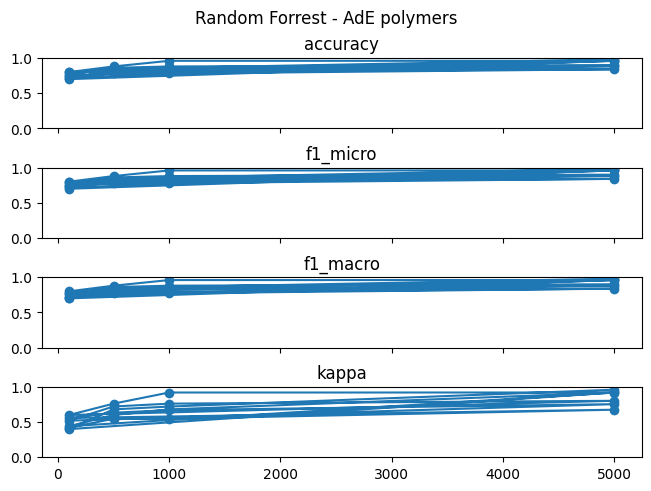

In [9]:
import matplotlib.pyplot as plt

METRICS = ['accuracy','f1_micro','f1_macro', 'kappa']
fig, ax = plt.subplots(len(METRICS), 1, sharex=True, layout = 'constrained')
ax = ax.flatten()

for i, metric in enumerate(METRICS):
    ax[i].plot(df['train_size'], df[metric], marker = 'o')
    ax[i].set_title(metric)
    ax[i].set_ylim(0,1)

fig.suptitle('Random Forrest - AdE polymers')